<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Exericse_and_Extra-curriculum/%F0%9F%9B%A0_07_Milestone_Project_1_%F0%9F%8D%94%F0%9F%91%81_Food_Vision_Big%E2%84%A2_Exercise_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛠 07. Milestone Project 1: 🍔👁 Food Vision Big™ Exercise Solution

The chief exercise for Milestone Project 1 is to finish the "TODO" sections in the Milestone Project 1 Template notebook. After doing so, move onto the following.

1. Retrain the model (feature extraction and fine-tuning) we trained in this notebook, except this time use `EfficientNetB4` as the base model instead of `EfficientNetB0`. Do you notice an improvement in performance? Does it take longer to train? Are there any tradeoffs to consider?

2. Name one important benefit of mixed precision training, how does this benefit take place?

3. Use the same evaluation techniques on the large-scale Food Vision model as you did in the previous notebook ([Transfer Learning Part 3: Scaling up](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb)). More specifically, it would be good to see:
  - A confusion matrix between all of the model's predictions and true labels.
  - A graph showing the f1-scores of each class.
  - A visualization of the model making predictions on various images and comparing the predictions to the ground truth.
    - For example, plot a sample image from the test dataset and have the title of the plot show the prediction, the prediction probability and the ground truth label.

4. Take 3 of your own photos of food and use the Food Vision model to make predictions on them. How does it go? Share your images/predictions with the other students.


#### Note
Using Mixed precision eith EfficientNetB0 model will throw you an error. The error happens when you turn on mixed precision training for EfficientNetBX models (if you're not sure what this is, you'll see it in the next video).

It'll look something like this:

`TypeError: Input 'y' of 'Sub' Op has type float16 that does not match type float32 of argument 'x'`


As of 29 May 2021 it looks like this is a bug in TensorFlow 2.5+.

There is an issue thread tracking the progress of an update on GitHub: https://github.com/tensorflow/tensorflow/issues/49725

**How to fix it**
The current workaround is to *downgrade* to TensorFlow 2.4.1 (the last version before 2.5).

You can do this in Google Colab by running:

``` 
# Downgrade Tensorflow Version (run this in Google Colab)
!pip install tensorflow==2.4.1
```
After doing so, you'll have to restart your runtime `(Runtime -> Restart runtime)` to ensure TensorFlow 2.4.1 is active.

**Check if TensorFlow 2.4.1 is active**
```
import tensorflow as tf
tf.__version__

>>> '2.4.1' 
```
Once TensorFlow 2.4.1 is installed, the code should work as normal.

If you have any issues, please post your question/reply below so others can see.

If a fix for this issue comes for TensorFlow 2.5+ (it should), we'll update this post.

Happy mixed precision training,

To read the whole discussion: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/82

In [ ]:
# Downgrade tensorflow to 2.4 from 2.5 version
!pip install tensorflow==2.4.1

## Getting the data ready! 

In here we will get the data and other tools we will be needing to solve our exercises. 

In [1]:
# Make sure to have Tesla T4 in order to use mixed precision
!nvidia-smi 

Fri Jul  9 02:04:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Importing the needed packages 
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow_datasets as tfds


# Get the helper function py
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

#Import series of helper functions for the notebook 
from helper_functions import plot_loss_curves, compare_historys

--2021-07-09 02:04:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-09 02:04:49 (88.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Use tensorflow dataset to download our data 

# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", 
                                             split=["train", "validation"], 
                                             shuffle_files=True, 
                                             as_supervised=True, 
                                             with_info=True) 

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteMJOWBS/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteMJOWBS/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [4]:
# Get class names
class_names = ds_info.features["label"].names

# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) 
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

# Create ModelCheckpoint callback to save our model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc", 
                                                      save_best_only=True, 
                                                      save_weights_only=True,
                                                      verbose=0) 
# How our dataset object looks like? 
train_data , test_data 

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [5]:
# Setup mixed precision 
from tensorflow.keras import mixed_precision 
mixed_precision.set_global_policy(policy = 'mixed_float16')

# Cross-checking if mixed precision worked
mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


<Policy "mixed_float16">

### 1. Retrain the model (feature extraction and fine-tuning) we trained in this notebook, except this time use `EfficientNetB4` as the base model instead of `EfficientNetB0`. Do you notice an improvement in performance? Does it take longer to train? Are there any tradeoffs to consider?

Buidling a feature extraction model with mixed precision turned on


In [6]:
# Importing the keras layer 
from tensorflow.keras import layers 

# Create the base model with EfficientNetB4 
input_shape = (224 , 224 , 3)
base_model = tf.keras.applications.EfficientNetB4(include_top = False)

# Freeze the model layers 
base_model.trainable = False 

# Building a functional model 
inputs = layers.Input(shape = input_shape , name = 'input_layer')
x = base_model(inputs , training = False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)

# Separate activation for the output layer so we can output float32 activations in output 
outputs = layers.Activation('softmax' , name ='softmax_float32_activations' , dtype = tf.float32)(x)

# Packing everything into a model 
model = tf.keras.Model(inputs , outputs)

# Compiling the model 
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
              optimizer = tf.keras.optimizers.Adam() , 
              metrics = ['accuracy'])

71688192/71686520 [==============================] - 0s 0us/step


In [7]:
# Summary of the model 
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, None, None, 1792)  17673823  
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               181093    
_________________________________________________________________
softmax_float32_activations  (None, 101)               0         
Total params: 17,854,916
Trainable params: 181,093
Non-trainable params: 17,673,823
_________________________________________________________________


In [8]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb4 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32_activations True float32 <Policy "float32">


In [9]:
# Training a feature extraction model 

initial_epochs = 4 
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=4,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[model_checkpoint])

Epoch 1/4
2368/2368 [==============================] - 267s 92ms/step - loss: 2.3193 - accuracy: 0.4575 - val_loss: 1.3159 - val_accuracy: 0.6557
Epoch 2/4
2368/2368 [==============================] - 220s 89ms/step - loss: 1.3921 - accuracy: 0.6388 - val_loss: 1.2452 - val_accuracy: 0.6724
Epoch 3/4
2368/2368 [==============================] - 209s 88ms/step - loss: 1.2401 - accuracy: 0.6755 - val_loss: 1.2011 - val_accuracy: 0.6862
Epoch 4/4
2368/2368 [==============================] - 210s 88ms/step - loss: 1.1264 - accuracy: 0.7030 - val_loss: 1.1850 - val_accuracy: 0.6838


Creating some handful of useful callbacks for our massive training!

In [10]:
# Creating a Early Stopping callback to stop training if models val loss doesn't improve for 3 epochs 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss' , 
                                                  patience = 3)

# Create a modelcheckpoint callback to save the best model during fine tuning 
fine_tune_checkpoint_path = 'fine_tine_checkpoints/'
fine_tune_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(fine_tune_checkpoint_path , 
                                                                save_best_only = True , 
                                                                monitor = 'val_loss')

# Creating learning rate reduction callback 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= 'val_loss' , 
                                                 factor = 0.2 , 
                                                 patience = 2 , 
                                                 verbose = 1 , 
                                                 min_lr = 1e-7)

In [11]:
# Are any of the layers in our model is frozen? 
for layers in model.layers:
  print(layers.name , layers.trainable , layers.dtype)

input_layer True float32
efficientnetb4 False float32
pooling_layer True float32
dense True float32
softmax_float32_activations True float32


In [12]:
# Unfreezing all the layers and make them all trainable (We are going to fine tune on the whole network)
for layer in model.layers:
  layer.trainable = True 

  # Checking if everything is True 
  print(layer.name , layer.trainable , layer.dtype)

input_layer True float32
efficientnetb4 True float32
pooling_layer True float32
dense True float32
softmax_float32_activations True float32


In [13]:
# Check the layers in the base model and see what dtype policy they're using 
for layer in model.layers[1].layers[:20]:
  print(layer.name , layer.trainable , layer.dtype , layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block1b_dwconv True float32 <Policy "mixed_float16">
block1b_bn True float32 <Policy "mixed_float16">
block1b

In [14]:
# Re-compiling the model to make sure with the changes 
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
              optimizer = tf.keras.optimizers.Adam() , 
              metrics = ['accuracy'])

In [15]:
# Fitting the model (Gonna be training for 100 epochs)
history_101_food_classes_all_data_fine_tune = model.fit(train_data , 
                                                        epochs = 100 , 
                                                        steps_per_epoch = len(train_data) , 
                                                        validation_data = test_data , 
                                                        validation_steps = int(0.15 * len(test_data)) , 
                                                        callbacks = [fine_tune_model_checkpoint ,  
                                                                     early_stopping , 
                                                                     reduce_lr])

Epoch 1/100
2368/2368 [==============================] - 671s 273ms/step - loss: 2.1423 - accuracy: 0.4677 - val_loss: 1.3096 - val_accuracy: 0.6478
INFO:tensorflow:Assets written to: fine_tine_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tine_checkpoints/assets


Epoch 2/100
2368/2368 [==============================] - 646s 272ms/step - loss: 1.5343 - accuracy: 0.6007 - val_loss: 1.4292 - val_accuracy: 0.6194
Epoch 3/100
2368/2368 [==============================] - 646s 272ms/step - loss: 1.5636 - accuracy: 0.5948 - val_loss: 1.6484 - val_accuracy: 0.5847

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/100
2368/2368 [==============================] - 645s 272ms/step - loss: 1.0076 - accuracy: 0.7322 - val_loss: 0.7913 - val_accuracy: 0.7799
INFO:tensorflow:Assets written to: fine_tine_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tine_checkpoints/assets


Epoch 5/100
2368/2368 [==============================] - 644s 271ms/step - loss: 0.6536 - accuracy: 0.8193 - val_loss: 0.7922 - val_accuracy: 0.7826
Epoch 6/100
2368/2368 [==============================] - 643s 271ms/step - loss: 0.4315 - accuracy: 0.8766 - val_loss: 0.8808 - val_accuracy: 0.7881

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 7/100
2368/2368 [==============================] - 642s 271ms/step - loss: 0.1787 - accuracy: 0.9511 - val_loss: 0.9890 - val_accuracy: 0.8001


We could see that there wasn't a bigger difference in performance, but `EfficientNetB4` was training much longer per epoch than the `EfficientNetB0` model.

### 2. Name one important benefit of mixed precision training, how does this benefit take place?

Speeds up memory-limited operations by accessing half the bytes compared to single-precision. Reduces memory requirements for training models, enabling larger models or larger minibatches.

In our feature extraction model and the fine tuning one it helped us by speeding up the training. 



### 3. Use the same evaluation techniques on the large-scale Food Vision model as you did in the previous notebook ([Transfer Learning Part 3: Scaling up](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb)). More specifically, it would be good to see:

  - A confusion matrix between all of the model's predictions and true labels.
  - A graph showing the f1-scores of each class.
  - A visualization of the model making predictions on various images and comparing the predictions to the ground truth.
    - For example, plot a sample image from the test dataset and have the title of the plot show the prediction, the prediction probability and the ground truth label.

In [36]:
pred_probs[:1]

array([[7.65346011e-13, 3.20966474e-12, 1.12399642e-15, 1.51363186e-10,
        1.51613834e-12, 1.01620441e-10, 3.37993288e-19, 2.34540906e-07,
        2.59303255e-15, 1.09630751e-12, 9.41672851e-11, 1.64229619e-13,
        1.48280529e-17, 3.17704991e-15, 1.34776856e-09, 6.82145486e-12,
        1.13281202e-15, 1.54511846e-16, 3.22415197e-08, 5.48119319e-12,
        4.49923735e-13, 2.10875005e-13, 1.72111159e-13, 1.75084860e-16,
        2.50797482e-16, 2.77024491e-17, 8.32523720e-12, 1.05146633e-17,
        1.99533268e-17, 1.31685053e-14, 2.70038901e-18, 1.81403846e-14,
        6.87495633e-12, 1.28209610e-10, 5.62298506e-11, 3.33652715e-14,
        6.22036178e-15, 2.69793771e-11, 2.48471464e-13, 1.71388985e-15,
        4.08799852e-14, 3.13437732e-14, 8.01596975e-17, 3.61685848e-10,
        9.66609878e-06, 1.56755789e-11, 1.30660287e-14, 8.67250661e-13,
        2.40826835e-13, 3.10812867e-18, 7.45146966e-09, 1.01911613e-17,
        1.54279448e-13, 3.53681148e-16, 8.21096446e-13, 4.779354

In [43]:
# Making prediction with our model 
pred_probs = model.predict(test_data)

# Get the class prediction of each label 
pred_classes = pred_probs.argmax(axis = 1)

# Unravelling our test lables (Don't use unbatch)
y_labels = [] 
for images , labels in test_data:
  y_labels.append(labels.numpy().argmax())

# How does our true labels and predicted labels look like? 
y_labels[:5] , pred_classes[:5]

([2, 26, 19, 7, 29], array([48, 57, 79, 15, 81]))

In [47]:
len(pred_classes)

25250

In [46]:
# Does label and predictions are equal in size? 
len(y_labels) == len(pred_classes)

False

**At first let's build a confusion matrix of all the model's predictions and true labels.**

In [20]:
# Creating a function for plotting the confusion matrix

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

# Using the above function and plotting our confusion matrix 
make_confusion_matrix(y_true= y_labels , 
                      y_pred = pred_classes , 
                      classes = class_names , 
                      figsize = (100 , 100), 
                      text_size = 20 , 
                      norm = False , 
                      savefig = False)


In [26]:
y_labels[:2] , pred_classes[:4]

([0, 0], array([70, 65, 34, 69]))

In [30]:
cm = tf.math.confusion_matrix(y_labels, pred_classes)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(32.09374999999999, 0.5, 'True')

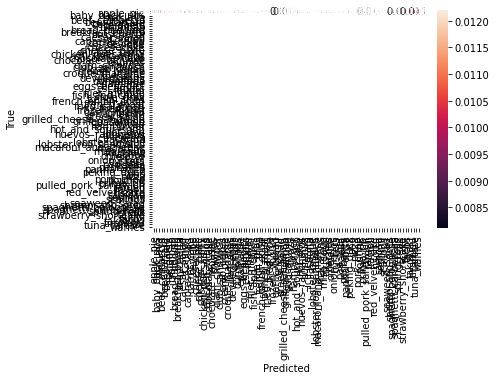

In [32]:
import seaborn as sns 

sns.heatmap(
    cm, annot=True,
    xticklabels=class_names,
    yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")


**A graph showing F1 class of each class** 

In [49]:
# Using the classification report from sklearn 
from sklearn.metrics import classification_report
print(classification_report(y_labels , pred_classes))

ValueError: ignored